# **1. Consensus atom mapping**

In [ ]:
import sys
sys.path.append('../../')
from SynTemp.SynAAM.run_consensus import run_consensus_aam
from SynTemp.SynUtils.utils import load_database
folder_name = 'uspto_sample'
save_dir = f'../../Data/{folder_name}'
data = load_database(f'../../Data/{folder_name}/{folder_name}_reactions.json.gz')
mapped_reactions = run_consensus_aam(data, save_dir=None, data_name = folder_name, batch_size=50, check_balance=False, verbose=2)

# **2. ITSG and Rule Extraction**

Assume that you run consensus atom mapping (take time)

## 2.1. Extraction

In [2]:
import sys
sys.path.append('../../')
from SynTemp.SynAAM.aam_postprocess import AMMPostprocessor
from SynTemp.SynITS.its_extraction import ITSExtraction
from SynTemp.SynUtils.utils import load_database, save_database

data = load_database(f'../../Data/uspto/uspto_balance_aam_reactions.json.gz')
mapper_name = ['rxn_mapper', 'graphormer', 'local_mapper']

# make sure reactions all have atom mapping
check_valid = AMMPostprocessor.parallel_postprocess(data, mapper_name, threshold=3, n_jobs=5, verbose=1)
valid_data = [reaction for reaction in check_valid if reaction.get('Valid')]

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.


[Parallel(n_jobs=5)]: Done  65 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 1065 out of 1074 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=5)]: Done 1074 out of 1074 | elapsed:    0.6s finished


In [3]:
len(data)

1074

In [4]:
# Extract rules and graph rules based on Imaginary Transition State (ITS)
its_graph, its_graph_wrong = ITSExtraction.parallel_process_smiles(valid_data, mapper_name, threshold=2, n_jobs=5, verbose=1, export_full=False, check_method='RC')

len(its_graph)

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  80 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 1074 out of 1074 | elapsed:    3.3s finished


1012

In [ ]:
its_graph_wrong[1]

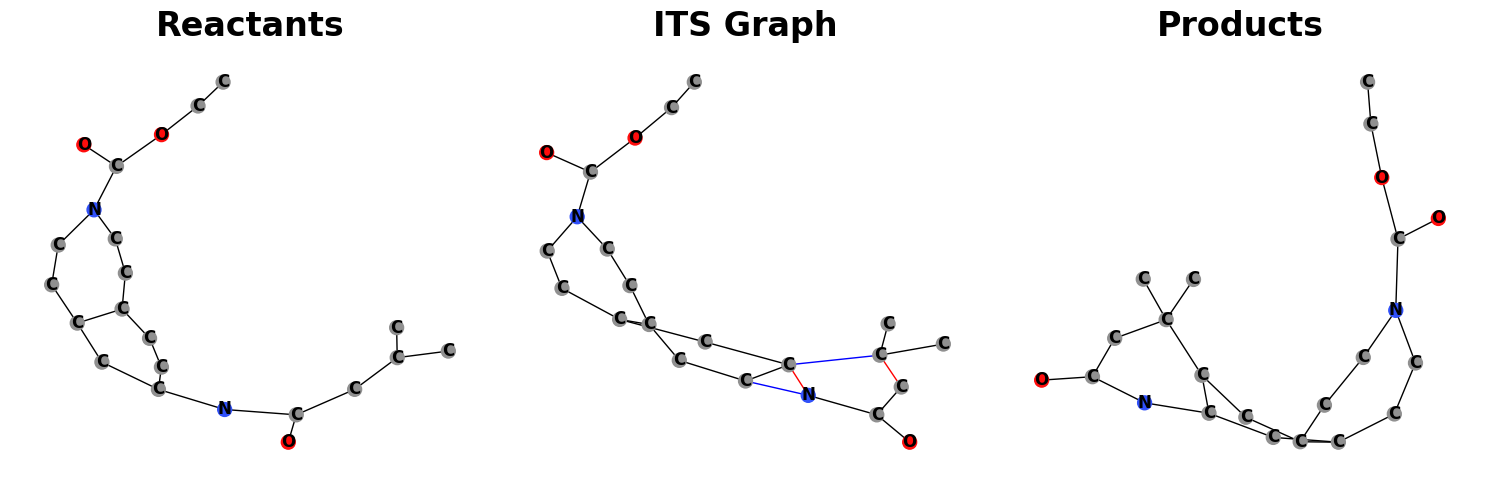

In [5]:
from SynTemp.SynVis.chemical_graph_visualizer import ChemicalGraphVisualizer
vis_graph = ChemicalGraphVisualizer(seed=42)
vis_graph.visualize_all(its_graph_wrong[1]['rxn_mapper'])

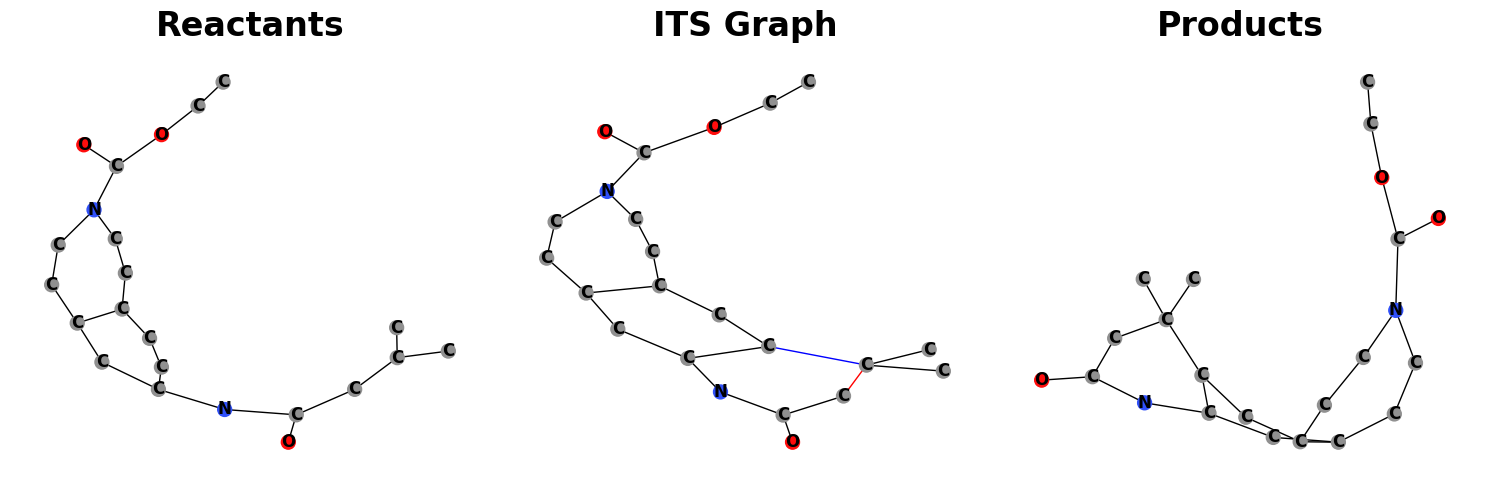

In [6]:
vis_graph.visualize_all(its_graph_wrong[1]['local_mapper'])

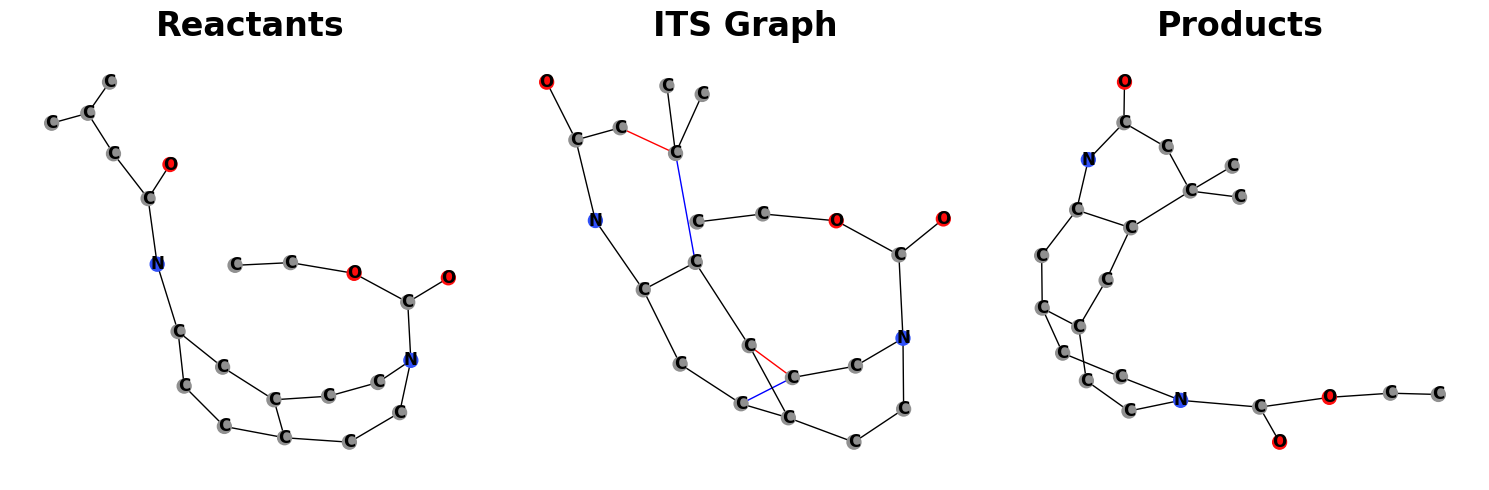

In [7]:
vis_graph.visualize_all(its_graph_wrong[1]['graphormer'])

In [8]:
valid_data[0]

{'balanced': True,
 'R-id': 'USPTO_50K_26',
 'reactions': 'Clc1cnc2nc1Nc1ccc(OCCC3CCNCC3)c(c1)CCc1cncc(c1)N2.O=C=NCc1ccco1>>O=C(NCc1ccco1)N1CCC(CCOc2ccc3cc2CCc2cncc(c2)Nc2ncc(Cl)c(n2)N3)CC1',
 'local_mapper': '[Cl:36][c:35]1[cH:34][n:33][c:32]2[n:38][c:37]1[NH:39][c:20]1[cH:19][cH:18][c:17]([O:16][CH2:15][CH2:14][CH:13]3[CH2:12][CH2:11][NH:10][CH2:41][CH2:40]3)[c:22]([cH:21]1)[CH2:23][CH2:24][c:25]1[cH:26][n:27][cH:28][c:29]([cH:30]1)[NH:31]2.[O:1]=[C:2]=[N:3][CH2:4][c:5]1[cH:6][cH:7][cH:8][o:9]1>>[O:1]=[C:2]([NH:3][CH2:4][c:5]1[cH:6][cH:7][cH:8][o:9]1)[N:10]1[CH2:11][CH2:12][CH:13]([CH2:14][CH2:15][O:16][c:17]2[cH:18][cH:19][c:20]3[cH:21][c:22]2[CH2:23][CH2:24][c:25]2[cH:26][n:27][cH:28][c:29]([cH:30]2)[NH:31][c:32]2[n:33][cH:34][c:35]([Cl:36])[c:37]([n:38]2)[NH:39]3)[CH2:40][CH2:41]1',
 'rxn_mapper': '[Cl:36][c:35]1[cH:34][n:33][c:32]2[n:38][c:37]1[NH:39][c:20]1[cH:19][cH:18][c:17]([O:16][CH2:15][CH2:14][CH:13]3[CH2:12][CH2:11][NH:10][CH2:41][CH2:40]3)[c:22]([cH:21]1)[CH2:23][CH2:24]

In [ ]:
len(its_graph_wrong)

In [ ]:
from SynTemp.SynVis.chemical_graph_visualizer import ChemicalGraphVisualizer
vis = ChemicalGraphVisualizer(seed=42)
vis.visualize_all(its_graph[0]['ITSGraph'])

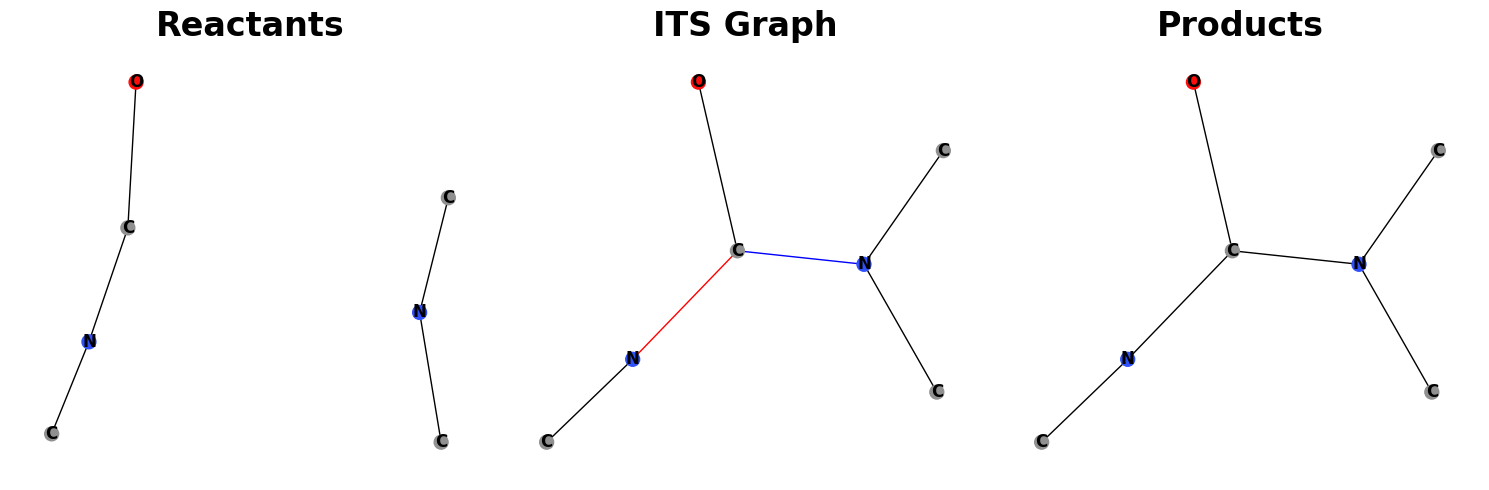

In [13]:
vis = ChemicalGraphVisualizer(seed=42)
vis.visualize_all(its_graph[0]['GraphRules'])

## 2.2. Rules Extension

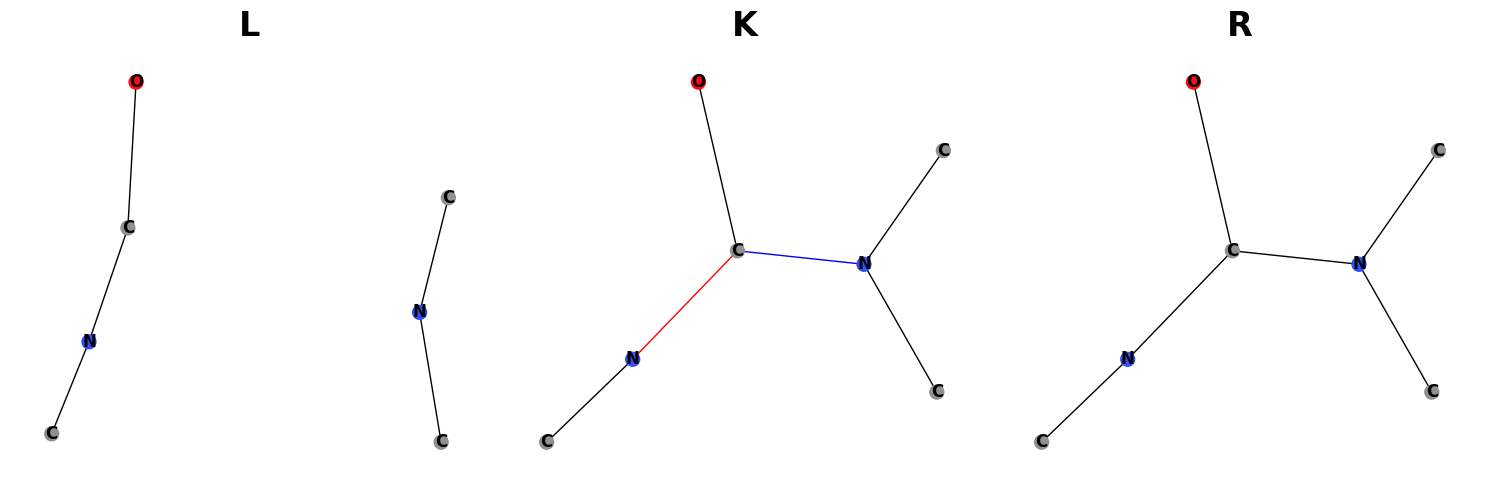

In [14]:
from SynTemp.SynRule.rules_extraction import RuleExtraction
its_graph_rules = RuleExtraction.process_rules_extraction(its_graph, mapper_type='ITSGraph', n_jobs=1, verbose=0, extend=True, n_knn=1)
vis.visualize_all(its_graph_rules[0]['GraphRules'], left_graph_title='L', right_graph_title='R', k_graph_title='K')

# **3. ITS Hydrogen Adjuster**

Make sure ITSG be a cyclic graph

## 3.1. Cyclic ITS Graph

In [15]:
from SynTemp.SynITS.its_hadjuster import ITSHAdjuster

from copy import deepcopy

test_list = deepcopy(its_graph)
print(len(test_list))

process_graph_data = ITSHAdjuster.process_graph_data_parallel(test_list, 'ITSGraph', n_jobs=5, verbose=2)
process_graph_data= [value for _, value in enumerate(process_graph_data) if value['ITSGraph'] is not None]
len(process_graph_data)

1012


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done 1012 out of 1012 | elapsed:    0.7s finished


1012

In [26]:
test = [value for value in valid_data if value['R-id']=='USPTO_50K_52']
test

[{'balanced': True,
  'R-id': 'USPTO_50K_52',
  'reactions': 'CNc1cccc(N)c1C#N.O=C=NC(=O)c1ccccc1>>CNc1cccc(NC(=O)NC(=O)c2ccccc2)c1C#N',
  'local_mapper': '[CH3:1][NH:2][c:3]1[cH:4][cH:5][cH:6][c:7]([NH2:8])[c:20]1[C:21]#[N:22].[O:10]=[C:9]=[N:11][C:12](=[O:13])[c:14]1[cH:15][cH:16][cH:17][cH:18][cH:19]1>>[CH3:1][NH:2][c:3]1[cH:4][cH:5][cH:6][c:7]([NH:8][C:9](=[O:10])[NH:11][C:12](=[O:13])[c:14]2[cH:15][cH:16][cH:17][cH:18][cH:19]2)[c:20]1[C:21]#[N:22]',
  'rxn_mapper': '[CH3:1][NH:2][c:3]1[cH:4][cH:5][cH:6][c:7]([NH2:8])[c:20]1[C:21]#[N:22].[O:10]=[C:9]=[N:11][C:12](=[O:13])[c:14]1[cH:15][cH:16][cH:17][cH:18][cH:19]1>>[CH3:1][NH:2][c:3]1[cH:4][cH:5][cH:6][c:7]([NH:8][C:9](=[O:10])[NH:11][C:12](=[O:13])[c:14]2[cH:15][cH:16][cH:17][cH:18][cH:19]2)[c:20]1[C:21]#[N:22]',
  'graphormer': '[NH2:8][c:7]1[cH:6][cH:5][cH:4][c:3]([NH:2][CH3:1])[c:9]1[C:10]#[N:11].[cH:19]1[cH:18][c:17]([cH:22][cH:21][cH:20]1)[C:15]([N:14]=[C:13]=[O:12])=[O:16]>>[cH:18]1[cH:19][cH:20][cH:21][cH:22][c:17]1[C:15](=

In [25]:
process_graph_data[2]

{'R-id': 'USPTO_50K_52',
 'ITSGraph': (<networkx.classes.graph.Graph at 0x29fe4a510>,
  <networkx.classes.graph.Graph at 0x29ff06b90>),
 'GraphRules': (<networkx.classes.graph.Graph at 0x29ff5ffd0>,
  <networkx.classes.graph.Graph at 0x2a081f210>)}

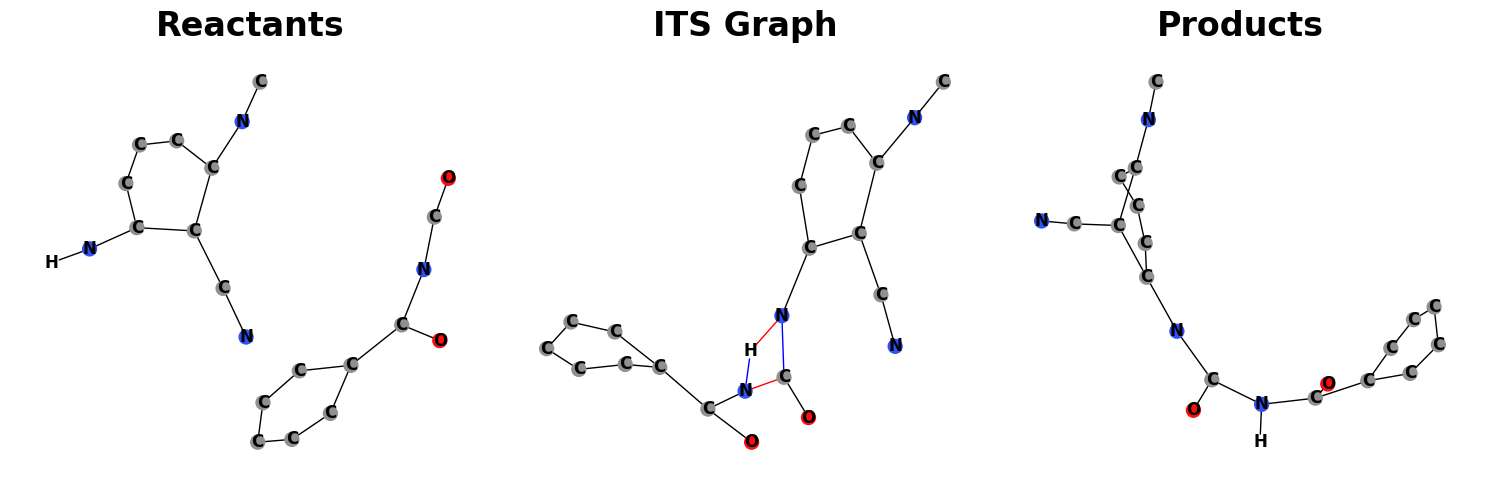

In [24]:
vis.visualize_all(process_graph_data[2]['ITSGraph'])

## 2.2. Uncertain atom mapping refinement

In [ ]:
from SynTemp.SynITS.its_refinement import UncertainRefinement
from SynTemp.SynUtils.utils import load_from_pickle

In [ ]:
from SynTemp.SynVis.chemical_graph_visualizer import ChemicalGraphVisualizer
vis = ChemicalGraphVisualizer(seed=42)
vis.visualize_all(its_graph_wrong[0]['local_mapper'])

In [ ]:
its_graph_wrong

In [ ]:
vis.visualize_all(its_graph_wrong[0]['rxn_mapper'])

In [ ]:
process_graphs = UncertainRefinement.process_graphs_in_parallel(its_graph_wrong, n_jobs=1, verbose=1)
print(len(process_graphs))

process_graphs = [value for key, value in enumerate(process_graphs) if value is not None]
print(len(process_graphs))

In [ ]:
vis.visualize_all(process_graphs[0]['GraphRules'])

# **4. Graph Modelling Language - MØD_rules** 

In [ ]:
from SynTemp.SynMØD.MØD_rules import MØDRules
results = MØDRules.auto_extraction(bug, reindex=True, save_path=None, rule_column='GraphRules', n_jobs=1, attributes=['charge', 'isomer'])
print(results[0])

print(results[1])

In [ ]:
from SynTemp.SynMØD.MØD_rules import MØDRules
results = MØDRules.auto_extraction(process_graphs, reindex=True, save_path='../../Data/uspto/Rule/', rule_column='GraphRules')
print(results[0])

In [ ]:
len(process_graphs)

In [ ]:
id = [value['R-id'] for value in process_graphs]
test_data = [value for value in valid_data if value['R-id'] in id]
test_data = [{'R-id': value['R-id'], 'reactions': value['reactions']} for value in test_data]
save_database(test_data, '../../test_database.json')

In [ ]:
process_graphs[0]

In [ ]:
process_graphs[0]

In [ ]:
vis.visualize_all(process_graphs[0]['ITSGraph'], left_graph_title='L', right_graph_title='R', k_graph_title='K')

In [ ]:
data = load_database('../..//Data/uspto/uspto_balance_reactions.json.gz')

In [ ]:
test= [value for value in data if value['R-id']=='USPTO_50K_31']

In [ ]:
test

# **5. MolToGraph**

In [ ]:
from SynTemp.SynUtils.utils import load_database, load_from_pickle
from SynTemp.SynChemistry.mol_to_graph import MolToGraph
from SynTemp.SynChemistry.graph_to_mol import GraphToMol

graph_test = its_graph_rules[0]['GraphRules'][2]

In [ ]:
from rdkit import Chem
converter = MolToGraph()
smiles = "[NH2:4][c:5]1[cH:6][cH:7][cH:8][c:9]2[cH:10][n:11][cH:12][cH:13][c:14]12"  
mol = Chem.MolFromSmiles(smiles)
display(mol)
graph = converter.mol_to_graph(mol)

# Display some graph details
print("Nodes and their attributes:")
print(graph.nodes(data=True))
print("\nEdges and their attributes:")
print(graph.edges(data=True))

In [ ]:
from SynTemp.SynVis.chemical_graph_vis import ChemicalGraphVisualizer
vis = ChemicalGraphVisualizer(seed=42)
vis.graph_vis(graph)

In [ ]:
node_attributes = {
    'element': 'element',
    'charge': 'charge',
    'atom_atom_map': 'atom_atom_map'
}
edge_attributes = {
    'order': 'order'
}
converter = GraphToMol(node_attributes, edge_attributes)

# Convert graph to RDKit Mol
mol = converter.graph_to_mol(graph)
display(mol)
print(Chem.MolToSmiles(mol))


# **6. Graph Rules alignment**

In [ ]:
import sys
sys.path.append('../')
from SynTemp.SynUtils.utils import load_database, load_from_pickle
from SynTemp.SynRule.rules_extraction import GraphRuleExtraction
from SynTemp.SynVis.chemical_graph_vis import ChemicalGraphVisualizer

process_graph_data[0]

In [ ]:
from SynTemp.SynRule.rules_extraction import GraphRuleExtraction
from SynTemp.SynMØD.naive_cluster import NaiveCluster
node_label_names=["element", "aromatic", "charge"]
node_label_names=["element", "charge"]
naive_cluster =  NaiveCluster(node_label_names=node_label_names,
                           node_label_default=["*", False, 0], edge_attribute="order")

its_graph_rules_cluster = naive_cluster.process_rules_clustering(process_graph_data, rule_column='GraphRules')
naive = [{'R-id': d['R-id'], 'naive_cluster': d['naive_cluster']} for d in its_graph_rules_cluster]
r_id = [d['R-id'] for d in naive]
its_graph_rules_cluster[0]

In [ ]:
import pandas as pd
pd.DataFrame(naive)['naive_cluster'].value_counts()

In [ ]:
from SynTemp.SynUtils.utils import stratified_random_sample
sampled_data = stratified_random_sample(its_graph_rules_cluster, property_key='naive_cluster', samples_per_class=1, seed=42)

In [ ]:
vis.visualize_all(sampled_data[13]['GraphRules'])

# **7. Unbalance reaction**

In [ ]:
import sys
sys.path.append('../../')

In [ ]:
from SynTemp.SynUtils.utils import load_database
import pandas as pd
unb = load_database('../../Data/jaworski/jaworski_aam_reactions.json.gz')

mapper_name = ['graphormer', 'local_mapper', 'rxn_mapper']

from SynTemp.SynITS.its_extraction import ITSExtraction
correct, incorrect = ITSExtraction.parallel_process_smiles(unb, mapper_name, n_jobs=4, threshold=2)

len(correct), len(incorrect)

# **8. Arbitrary Hydrogen**

In [ ]:
from rdkit import Chem
test = '[CH:10]=1[CH:11]=[CH:12][C:7](=[CH:8][CH:9]=1)[N:5]([OH:6])[C:3](=[O:4])[O:2][CH3:1].[Cl:16][C:14]([Cl:13])([Cl:15])[C:17]#[N:18]>>[Cl:13][C:14]([Cl:16])([Cl:15])[C:17]([NH:18][C:12]=1[C:7](=[CH:8][CH:9]=[CH:10][CH:11]=1)[NH:5][C:3]([O:2][CH3:1])=[O:4])=[O:6]'
from SynTemp.SynVis.reaction_visualizer import ReactionVisualizer
vis = ReactionVisualizer()
vis.visualize_reaction(test)

In [ ]:
test_arbitrary = [{'R-id':'C1', 'mapper': test}]
from SynTemp.SynITS.its_extraction import ITSExtraction
mapper_names = ['mapper']
correct, incorrect = ITSExtraction.parallel_process_smiles(test_arbitrary, mapper_names=mapper_names, check_method='RC', threshold=0)
react_graph , product_graph, rule_graph = correct[0]['ITSGraph'][0], correct[0]['ITSGraph'][1], correct[0]['ITSGraph'][2]

In [ ]:
from SynTemp.SynITS.its_hadjuster import ITSHAdjuster
from SynTemp.SynITS.its_construction import ITSConstruction

variations = ITSHAdjuster.add_hydrogen_nodes_multiple(react_graph, product_graph)
its_list = [ITSConstruction.ITSGraph(i[0], i[1]) for i in variations]

group_1 , group_2 = variations[0] + (its_list[0],), variations[1] + (its_list[1],)
rules_1 = GraphRuleExtraction.extract_reaction_rules(*group_1, extend=False, n_knn=1)
rules_2 = GraphRuleExtraction.extract_reaction_rules(*group_2, extend=False, n_knn=1)

In [ ]:
from SynTemp.SynVis.chemical_graph_vis import ChemicalGraphVisualizer
vis = ChemicalGraphVisualizer(seed=42)
vis.visualize_all(rules_1, left_graph_title='L', right_graph_title='R', k_graph_title='K')

In [ ]:
vis.visualize_all(rules_2, left_graph_title='L', right_graph_title='R', k_graph_title='K')